# Approximating integrals on fractals
This notebook shows how to use ```IFSintegrals``` to approximate integrals of the form
$$
\frac{\int_\Gamma f(x)\mathrm{d}\mathcal{H}^d(x)}{\mathcal{H}^d(\Gamma)},
$$
over a fractal $\Gamma$ of Hausdorff dimension $d$, with respect to the measure $\mathcal{H}^d(\cdot)/\mathcal{H}^d(\Gamma)$, where $\mathcal{H}^d$ is the Hausdorff measure. We will also investigate double integrals
$$
\frac{\int_{\Gamma_1}\int_{\Gamma_2} f(x,y)\mathrm{d}\mathcal{H}^{d_2}(y)\mathrm{d}\mathcal{H}^{d_1}(x)}{\mathcal{H}^{d_1}(\Gamma)\mathcal{H}^{d_2}(\Gamma)}.
$$

The ideas presented in this tutorial are all based on the work of [this paper](http://arxiv.org/abs/2112.11793).

In $\S1$ of this tutorial we will focus on smooth $f$, and in $\S2$ weakly singular $f$ will be demonnstrated. But first, let's understand some basic principles of this Julia toolbox.

In [1]:
using IFSintegrals, Plots;

First, let's encode an iterated function system (IFS) describing some fractal attractor $\Gamma$. For a set $E\subset\mathbb{R}^n$, $n\in\mathbb{N}$, this will be of the form
$$
S(E):=\cup_{m=1}^M s_m(E),
$$
where $s_m(x):=A_m\rho_mx+\delta_m$ is a contracting similarity, where $A_m$ is a rotation matrix, $\rho_m<1$ and $\delta_m\in\mathbb{R}^n$, for $m=1,\ldots,M$. The attractor $\Gamma$ is uniquely defined as the compact set which satisfies $\Gamma=S(\Gamma)$.

In this Julia package, ```Similarity``` is a *type*, and can be constructed using the syntax ```Similarity(ρ,δ)``` with contraction $\rho$ and translation $\delta$. There is an optional third entry for a rotation matrix (this defaults to the identity matrix).

In this package, an IFS is represented an array of similarities. We can then represent the fractal $\Gamma$ using the ```Attractor``` type, as follows:

In [2]:
ρ = 0.41 # uniform contraction
IFS = [
    Similarity(ρ,[0,0])
    Similarity(ρ,[1-ρ,0])
    Similarity(ρ,[(1-ρ)/2,sqrt(3)*(1-ρ)/2])
    Similarity(ρ,[(1-ρ)/2,(1-ρ)/(2*sqrt(3))])
]
Γ = Attractor(IFS)

Attractor{StaticArrays.SVector{2, Float64}, StaticArrays.SMatrix{2, 2, Float64, 4}}(Similarity{StaticArrays.SVector{2, Float64}, StaticArrays.SMatrix{2, 2, Float64, 4}}[Similarity{StaticArrays.SVector{2, Float64}, StaticArrays.SMatrix{2, 2, Float64, 4}}(0.41, [0.0, 0.0], [1.0 0.0; 0.0 1.0], [0.41 0.0; 0.0 0.41]), Similarity{StaticArrays.SVector{2, Float64}, StaticArrays.SMatrix{2, 2, Float64, 4}}(0.41, [0.5900000000000001, 0.0], [1.0 0.0; 0.0 1.0], [0.41 0.0; 0.0 0.41]), Similarity{StaticArrays.SVector{2, Float64}, StaticArrays.SMatrix{2, 2, Float64, 4}}(0.41, [0.29500000000000004, 0.5109549882328188], [1.0 0.0; 0.0 1.0], [0.41 0.0; 0.0 0.41]), Similarity{StaticArrays.SVector{2, Float64}, StaticArrays.SMatrix{2, 2, Float64, 4}}(0.41, [0.29500000000000004, 0.17031832941093963], [1.0 0.0; 0.0 1.0], [0.41 0.0; 0.0 0.41])], 2, 1.5548421773629288, true, true, [0.5000000000000002, 0.28867513459481303], 1.0, 1.0, [0.25000000000000006, 0.25000000000000006, 0.25000000000000006, 0.25000000000000

In the background, the constructor for ```Attractor``` has computed all of the properties we might need for subsequent computations. These include:
* Hausdorff dimension
* Diameter
* Barycentre

In [3]:
println("d = ", Γ.Hausdorff_dimension)
println("diam(Γ) = ", Γ.diameter)
println("Barycentre of Γ: ", Γ.barycentre)

d = 1.5548421773629288
diam(Γ) = 1.0
Barycentre of Γ: [0.5000000000000002, 0.28867513459481303]


To view all of the properties of ```Γ``` in a notebook such as this, type ```Γ.``` and hit the tab key

Here we have defined our own ```Attractor``` from scratch, but there are several presets of popular fractals:
* ```CantorSet(β)```, [Cantor set](https://en.wikipedia.org/wiki/Cantor_set) with middle $\beta$ removed at each iteration ($\beta$ is optional and defaults to $\beta=1/3$)
* ```CantorDust(β)```, Cantor dust, the cartesian product of two Cantor sets with middle $\beta$ removed (again $\beta$ is optional)
* ```SquareFlake()```, the Square Snowflake, or [Minkowski island](https://en.wikipedia.org/wiki/Minkowski_sausage)
* ```KochFlake()```, the [Koch snowflake](https://en.wikipedia.org/wiki/Koch_snowflake)
* ```Sierpinski()```, the [Sierpinski triangle](https://en.wikipedia.org/wiki/Sierpiński_triangle)

We can *sketch* $\Gamma$, using the following the routine ```sketch_attractor```. This produces a set of points, which can then be visualised in the usual Julian way.

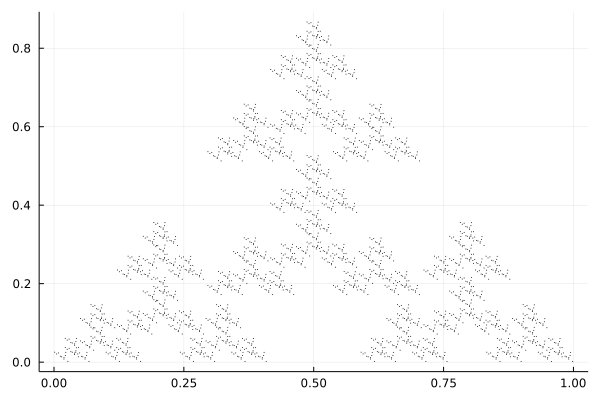

In [4]:
draw(Γ)

### 1. Barycentre rule

This quadrature rule works by partitioning $\Gamma$ into subsets, such that each subset is no more than $h$ in diameter, for some fixed $h>0$. On each subset, we approximate the integrand by a constant. This is the same principle as the classical midpoint rule. As in the classical case, we can reduce error by choosing a smaller $h$ (assuming the integrand is Lipschitz continuous).

Now let's choose an approximation parameter $h$, then get weights and nodes of the Barycentre Rule. These are $y_\mathbf{m}$ and $w_\mathbf{m}$ for $\mathbf{m}\in L_h(\Gamma)$.

In [5]:
h = 0.05
y, w = barycentre_rule(Γ,h)

([[0.014128805000000005, 0.008157269370077734], [0.054792194999999995, 0.008157269370077734], [0.034460500000000005, 0.04337279811407183], [0.034460500000000005, 0.0198957789514091], [0.11330780500000003, 0.008157269370077734], [0.063718305, 0.09404880289201457], [0.063718305, 0.03678778054405668], [0.256028805, 0.008157269370077734], [0.13507880500000002, 0.21764881454553345], [0.13507880500000002, 0.07798778442856298]  …  [0.5000000000000001, 0.3459361569427708], [0.91595, 0.048526290125388054], [0.6209500000000001, 0.5594812783582068], [0.6209500000000001, 0.2188446195363277], [0.7950000000000002, 0.2580178353008437], [0.5000000000000001, 0.7689728235336626], [0.5000000000000001, 0.4283361647117834], [0.7950000000000002, 0.11835680518387331], [0.5000000000000001, 0.6293117934166921], [0.5000000000000001, 0.288675134594813]], [0.0039062500000000035, 0.0039062500000000035, 0.0039062500000000035, 0.0039062500000000035, 0.0039062500000000035, 0.0039062500000000035, 0.0039062500000000035

Let's take a look at where the quadrature nodes sit. We should expect it to resemble our sketch $\Gamma$ a little.

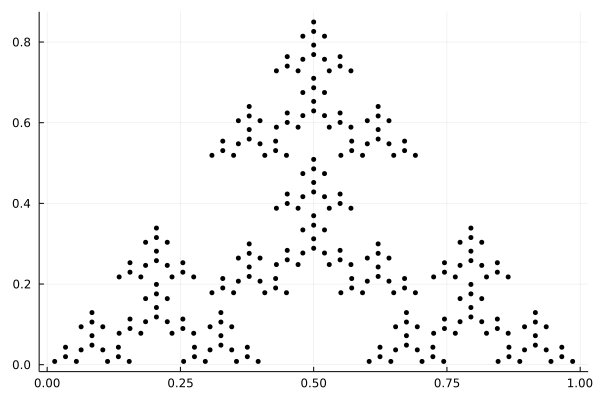

In [6]:
Y = permutedims(hcat(y...))
scatter(Y[:,1],Y[:,2],legend=:false,markerstrokewidth=0, markersize=3, markercolor="black")

Now suppose we want to evaluate
$$
\frac{\int_\Gamma f(y)\mathrm{d}\mathcal{H}^d(y)}{\mathcal{H}^d(\Gamma)}\approx I_h=\sum_{\mathbf{m}\in L_h(\Gamma)}w_\mathbf{m}f(y_\mathbf{m}).
$$
This can be done as follows, for this example take $f(x)=\sin(|x|)$:

In [7]:
using LinearAlgebra
f(x) = sin(sqrt(norm(x))) # define integrand
Ih = w'*f.(y)

0.6788741448009795

We could evaluate a double integral of the form:
$$
\frac{\int_{\Gamma_1}\int_{\Gamma_2} f(x,y)\mathrm{d}\mathcal{H}^{d_2}(y)\mathcal{H}^{d_1}(x)}{\mathcal{H}^{d_1}(\Gamma_1)\mathcal{H}^{d_2}(\Gamma_2)}\approx I_h=\sum_{\mathbf{m}\in L_h(\Gamma_1)}\sum_{\mathbf{m'}\in L_h(\Gamma_2)}w_\mathbf{m}f(x_\mathbf{m},y_\mathbf{m'}).
$$
For this example, let's take two different Cantor sets and $f(x,y)=\sin(|x|)\cos(|y|)$:

In [8]:
Γ₁ = CantorSet(contraction = 1/3) # this is actually the default value for optional argument contraction
Γ₂ = CantorSet(contraction = 1/4)
f(x,y) = sin(abs(x))*cos(abs(y))

x,y,w = barycentre_rule(Γ₁,Γ₂,h)
Ih = (w'*f.(x,y))

0.3657010333004295

### 2. Evaluating integrals of singular Green's functions

Suppose we want to approximate:
$$
I=\frac{\int_\Gamma\Phi_t(x,\xi_m)~\mathrm{d}\mathcal{H}^d(x)}{\mathcal{H}^d(\Gamma)}$$
where $\xi_m$ is a fixed point of $s_m$, and
$$
\Phi_t(x,y) = \left\{\begin{array}{ll}
|x-y|^{-t},&\quad t>0,\\
\log|x-y|,&\quad t=0.
\end{array}
\right.
$$

In [9]:
t = 1/2 # singularity strength
n = 2 #fixed point index, must be an integer
Ih = eval_green_single_integral_fixed_point(Γ, t, h, n)

1.4599772356543301

Now suppose we want to approximate
$$
\frac{\int_\Gamma\int_\Gamma\Phi_t(x,y)~\mathrm{d}\mathcal{H}^d(y)\mathrm{d}\mathcal{H}^d(x)}{(\mathcal{H}^d(\Gamma))^2}$$.
This double integral is singular, so it would be unwise to approach it with the Barycentre rule, as the approximation would be undefined. Fortunately there is a special routine for singular integrals within this class.

In [10]:
t = 1.0
I = eval_green_double_integral(Γ, t, h)

4.738268418342189

Finally, suppose we want to approximate
$$
\frac{\int_\Gamma\int_\Gamma\Phi(x,y)~\mathrm{d}\mathcal{H}^d(y)\mathrm{d}\mathcal{H}^d(x)}{(\mathcal{H}^d(\Gamma))^2}$$
where
$$
\Phi(x) = \left\{\begin{array}{ll}
\frac{\mathrm{i}}{4}H^{(1)}_0(k|x-y|),&\quad n=1,\\
\frac{\mathrm{e}^{\mathrm{i}k|x-y|}}{4\pi|x-y|},&\quad n=2.
\end{array}
\right.
$$
Note that for our fractal, $n=2$.

The integrand can be split into a singular component $\Phi_{n-1}/(4\pi)$ which can be evaluated using the method above, and a non-singular component, which can be evaluated using the barycentre rule described in $\S1$. There is a routine for doing this:

In [11]:
k = 1.96
Ih = singular_elliptic_double_integral(Γ, k, h)

0.32061136883392516 + 0.13651121576163744im

The optional parameter $c_{\mathrm{osc}}$ discussed in the paper can be adjusted as an optional parameter ```Cosc```:

In [12]:
Ih = singular_elliptic_double_integral(Γ, k, h; Cosc=1.5)

0.3199231911433777 + 0.13651121576163083im